In [96]:
import pyreadr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler

from dfply import *

# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical

# tf-explain for visual explanations
from tf_explain.core.gradients_inputs import GradientsInputs

import pydot

from scipy.stats import norm
from scipy import stats
import lime
from lime.lime_tabular import LimeTabularExplainer
from interpret.blackbox import LimeTabular
from interpret import show

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()


In [97]:
# Load the metadata
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category", "volume", "condition"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition
0,s104,46.0,29.0,0.42,Average_responder,3,RM10
1,s112,53.0,30.3,0.33,Average_responder,3,RM10
2,s13,46.0,25.3,0.92,High_responder,3,RM10
3,s130,58.0,29.9,0.26,Average_responder,3,RM10
4,s136,48.0,18.4,0.66,Average_responder,3,RM10
...,...,...,...,...,...,...,...
456,FP6w0R,21.8,20.5,0.09,No_responder,1,RM10
457,FP7w0L,21.2,28.2,0.73,Average_responder,3,RM10
458,FP7w0R,21.2,28.2,0.94,High_responder,1,RM10
459,FP9w0R,20.6,21.2,0.65,Average_responder,3,RM10


In [98]:
# AOData
AO_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_AO_counts.RDS")
AO_genecounts = AO_genecounts[None]
# Initialise the scaler
scaler = StandardScaler()
# scale
AO_scaled = scaler.fit_transform(AO_genecounts.iloc[:, 1:])
AO_scaled = pd.DataFrame(AO_scaled, columns = AO_genecounts.columns[1:])
AO_scaled = AO_scaled.round(2)
AO_scaled.insert(0, 'gene_id', AO_genecounts['gene_id'])
AO_scaled

,gene_id,s104,s112,s13,s130,s136,s147,s153,s159,s170,...,s822,s828,s859,s874,s875,s883,s89,s891,s903,s96
0,ENSG00000000003.16,-0.07,-0.07,-0.09,-0.09,-0.08,-0.08,-0.07,-0.06,-0.07,...,-0.07,-0.07,-0.08,-0.07,-0.07,-0.07,-0.07,-0.08,-0.07,-0.07
1,ENSG00000000419.14,-0.06,-0.06,-0.07,-0.07,-0.06,-0.06,-0.06,-0.05,-0.05,...,-0.06,-0.06,-0.07,-0.06,-0.06,-0.05,-0.06,-0.06,-0.06,-0.05
2,ENSG00000000457.14,-0.07,-0.07,-0.08,-0.08,-0.07,-0.07,-0.07,-0.06,-0.07,...,-0.06,-0.07,-0.08,-0.07,-0.07,-0.07,-0.07,-0.08,-0.07,-0.07
3,ENSG00000000971.17,-0.06,-0.06,-0.07,-0.07,-0.06,-0.06,-0.07,-0.05,-0.06,...,-0.06,-0.06,-0.04,-0.07,-0.06,-0.07,-0.06,-0.07,-0.06,-0.06
4,ENSG00000001036.14,-0.07,-0.07,-0.08,-0.09,-0.08,-0.07,-0.07,-0.06,-0.07,...,-0.07,-0.07,-0.08,-0.08,-0.07,-0.08,-0.07,-0.08,-0.07,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13408,ENSG00000310523.1,-0.06,-0.07,-0.06,-0.06,-0.07,-0.06,-0.06,-0.06,-0.06,...,-0.05,-0.06,-0.06,-0.06,-0.05,-0.06,-0.06,-0.06,-0.06,-0.06
13409,ENSG00000310526.1,-0.06,-0.05,-0.05,-0.05,-0.06,-0.05,-0.04,-0.05,-0.05,...,-0.04,-0.06,-0.05,-0.05,-0.05,-0.06,-0.06,-0.05,-0.05,-0.05
13410,ENSG00000310527.1,-0.06,-0.05,-0.05,-0.05,-0.06,-0.06,-0.05,-0.05,-0.06,...,-0.05,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.05,-0.06,-0.05
13411,ENSG00000310533.1,-0.07,-0.08,-0.09,-0.09,-0.08,-0.08,-0.07,-0.07,-0.07,...,-0.07,-0.07,-0.08,-0.08,-0.07,-0.07,-0.07,-0.08,-0.07,-0.07


In [99]:
# Contratrain
Contratrain_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_contratrain_counts.RDS")
Contratrain_genecounts = Contratrain_genecounts[None]
Contratrain_scaled = scaler.fit_transform(Contratrain_genecounts.iloc[:, 1:])
Contratrain_scaled = pd.DataFrame(Contratrain_scaled, columns = Contratrain_genecounts.columns[1:])
Contratrain_scaled = Contratrain_scaled.round(2)
Contratrain_scaled.insert(0, 'gene_id', Contratrain_genecounts['gene_id'])
Contratrain_scaled

,gene_id,X1.subj1sample1,X2.subj1sample6,X43.subj2sample4,X44.subj2sample6,X75.subj3sample5,X93.subj4sample5,X125.subj5sample4,X130.subj6sample6,X134.subj8sample4,...,X72.subj29sample6,X80.subj30sample4,X83.subj31sample5,X98.subj40sample7,X103.subj41sample2,X108.subj43sample3,X113.subj44sample4,X116.subj45sample4,X121.subj46sample7,X123.subj47sample2
0,ENSG00000000003.16,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,-0.07,...,-0.07,-0.07,-0.06,-0.07,-0.07,-0.07,-0.07,-0.06,-0.08,-0.08
1,ENSG00000000419.14,-0.04,-0.04,-0.04,-0.04,-0.05,-0.04,-0.04,-0.04,-0.05,...,-0.05,-0.04,-0.05,-0.04,-0.04,-0.04,-0.05,-0.05,-0.05,-0.05
2,ENSG00000000457.14,-0.07,-0.07,-0.06,-0.06,-0.07,-0.06,-0.06,-0.07,-0.07,...,-0.07,-0.07,-0.06,-0.07,-0.06,-0.07,-0.07,-0.06,-0.07,-0.07
3,ENSG00000000460.17,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,-0.08,...,-0.07,-0.08,-0.06,-0.07,-0.07,-0.07,-0.07,-0.06,-0.08,-0.08
4,ENSG00000000971.17,-0.06,-0.05,-0.05,-0.05,-0.06,-0.05,-0.05,-0.06,-0.06,...,-0.05,-0.06,-0.05,-0.05,-0.05,-0.06,-0.06,-0.03,-0.05,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,ENSG00000310523.1,-0.07,-0.07,-0.06,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,...,-0.07,-0.07,-0.05,-0.07,-0.06,-0.07,-0.07,-0.06,-0.07,-0.07
13775,ENSG00000310526.1,-0.07,-0.06,-0.05,-0.05,-0.06,-0.07,-0.06,-0.07,-0.07,...,-0.07,-0.07,-0.05,-0.06,-0.06,-0.07,-0.06,-0.06,-0.07,-0.05
13776,ENSG00000310527.1,-0.07,-0.07,-0.06,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,...,-0.07,-0.07,-0.05,-0.07,-0.06,-0.07,-0.07,-0.06,-0.07,-0.07
13777,ENSG00000310533.1,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,-0.07,...,-0.07,-0.08,-0.06,-0.07,-0.07,-0.07,-0.07,-0.06,-0.08,-0.08


In [100]:
# Copd
Copd_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_COPD_counts.RDS")
Copd_genecounts = Copd_genecounts[None]
Copd_scaled = scaler.fit_transform(Copd_genecounts.iloc[:, 1:])
Copd_scaled = pd.DataFrame(Copd_scaled, columns = Copd_genecounts.columns[1:])
Copd_scaled = Copd_scaled.round(2)
Copd_scaled.insert(0, 'gene_id', Copd_genecounts['gene_id'])
Copd_scaled

,gene_id,X102PreExcVLR12,X103PreExcVLR23,X105PreExcVLR38,X106PreExcVLR43,X110PreExcVLL58,X111PreExcVLL67,X111PreExcVLR69,X113PreExcVLL72,X113PreExcVLR74,...,X238PreExcVLL489,X239PreExcVLR496,X242PreExcVLR501,X242PreExcVLL506,X243PreExcVLL509,X243PreExcVLR510,X246PreExcVLR518,X246PreExcVLL519,X249PreExcVLL529,X250PreExcVLR538
0,ENSG00000000003.16,-0.09,-0.08,-0.08,-0.09,-0.07,-0.10,-0.09,-0.08,-0.09,...,-0.08,-0.08,-0.09,-0.10,-0.07,-0.08,-0.08,-0.07,-0.08,-0.07
1,ENSG00000000419.14,-0.04,-0.04,-0.05,-0.06,-0.05,-0.07,-0.06,-0.06,-0.06,...,-0.05,-0.06,-0.04,-0.05,-0.05,-0.06,-0.06,-0.05,-0.06,-0.05
2,ENSG00000000457.14,-0.09,-0.07,-0.08,-0.09,-0.07,-0.10,-0.09,-0.08,-0.08,...,-0.08,-0.08,-0.09,-0.09,-0.07,-0.07,-0.08,-0.07,-0.08,-0.07
3,ENSG00000000971.17,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.04,-0.06,-0.06,...,-0.05,-0.06,-0.05,-0.08,-0.05,-0.04,-0.06,-0.05,-0.06,-0.05
4,ENSG00000001036.14,-0.09,-0.08,-0.08,-0.09,-0.07,-0.10,-0.09,-0.08,-0.08,...,-0.08,-0.08,-0.09,-0.10,-0.07,-0.08,-0.08,-0.07,-0.08,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11313,ENSG00000310517.1,0.13,0.12,0.08,0.07,0.07,0.18,0.15,0.09,0.07,...,0.09,0.07,0.12,0.09,0.08,0.04,0.09,0.06,0.12,0.07
11314,ENSG00000310523.1,-0.09,-0.08,-0.08,-0.09,-0.07,-0.10,-0.09,-0.08,-0.08,...,-0.08,-0.08,-0.09,-0.09,-0.07,-0.08,-0.08,-0.07,-0.08,-0.07
11315,ENSG00000310526.1,-0.09,-0.07,-0.08,-0.08,-0.07,-0.09,-0.08,-0.08,-0.08,...,-0.08,-0.08,-0.09,-0.08,-0.07,-0.07,-0.08,-0.07,-0.08,-0.07
11316,ENSG00000310527.1,-0.09,-0.08,-0.08,-0.09,-0.07,-0.09,-0.09,-0.08,-0.08,...,-0.08,-0.08,-0.09,-0.08,-0.08,-0.08,-0.08,-0.07,-0.08,-0.07


In [101]:
# Relief
Relief_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_Relief_counts.RDS")
Relief_genecounts = Relief_genecounts[None]
Relief_scaled = scaler.fit_transform(Relief_genecounts.iloc[:, 1:])
Relief_scaled = pd.DataFrame(Relief_scaled, columns = Relief_genecounts.columns[1:])
Relief_scaled = Relief_scaled.round(2)
Relief_scaled.insert(0, 'gene_id', Relief_genecounts['gene_id'])
Relief_scaled

,gene_id,R_8,R_18,R_25,R_30,R_34,R_40,R_42,R_48,R_53,...,R_272,R_301,R_316,R_321,R_331,R_342,R_348,R_352,R_353,R_358
0,ENSG00000000003.16,-0.08,-0.06,-0.08,-0.08,-0.08,-0.08,-0.08,-0.08,-0.07,...,-0.06,-0.07,-0.06,-0.07,-0.08,-0.06,-0.07,-0.09,-0.08,-0.07
1,ENSG00000000419.14,-0.07,-0.05,-0.07,-0.06,-0.06,-0.07,-0.07,-0.06,-0.06,...,-0.05,-0.06,-0.05,-0.06,-0.06,-0.05,-0.05,-0.06,-0.06,-0.05
2,ENSG00000000457.14,-0.07,-0.06,-0.08,-0.08,-0.08,-0.08,-0.07,-0.07,-0.07,...,-0.06,-0.07,-0.06,-0.07,-0.07,-0.05,-0.06,-0.08,-0.07,-0.06
3,ENSG00000000460.17,-0.08,-0.07,-0.09,-0.08,-0.09,-0.09,-0.08,-0.08,-0.08,...,-0.07,-0.08,-0.07,-0.08,-0.08,-0.06,-0.07,-0.09,-0.08,-0.07
4,ENSG00000000971.17,-0.07,-0.06,-0.07,-0.06,-0.06,-0.07,-0.07,-0.06,-0.07,...,-0.05,-0.06,-0.03,-0.04,-0.04,-0.04,-0.05,-0.06,-0.05,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,ENSG00000310517.1,0.10,0.05,0.09,0.06,0.08,0.10,0.07,0.05,0.06,...,0.14,0.16,0.13,0.21,0.33,0.12,0.14,0.22,0.16,0.16
13228,ENSG00000310523.1,-0.06,-0.05,-0.06,-0.06,-0.07,-0.06,-0.06,-0.06,-0.06,...,-0.06,-0.07,-0.06,-0.07,-0.07,-0.05,-0.06,-0.07,-0.07,-0.07
13229,ENSG00000310526.1,-0.06,-0.05,-0.06,-0.05,-0.05,-0.05,-0.07,-0.05,-0.06,...,-0.05,-0.06,-0.05,-0.06,-0.06,-0.05,-0.06,-0.06,-0.06,-0.05
13230,ENSG00000310527.1,-0.07,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06,-0.05,-0.05,...,-0.06,-0.07,-0.06,-0.07,-0.07,-0.05,-0.07,-0.08,-0.07,-0.06


In [102]:
# Volume
Volume_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_vol_counts.RDS")
Volume_genecounts = Volume_genecounts[None]
Volume_scaled = scaler.fit_transform(Volume_genecounts.iloc[:, 1:])
Volume_scaled = pd.DataFrame(Volume_scaled, columns = Volume_genecounts.columns[1:])
Volume_scaled = Volume_scaled.round(2)
Volume_scaled.insert(0, 'gene_id', Volume_genecounts['gene_id'])
Volume_scaled

,gene_id,FP11w0R,FP11w0L,FP12w0R,FP12w0L,FP13w0L,FP13w0R,FP14w0R,FP14w0L,FP15w0R,...,FP46w0R,FP46w0L,FP5w0R,FP5w0L,FP6w0L,FP6w0R,FP7w0L,FP7w0R,FP9w0R,FP9w0L
0,ENSG00000000003.16,-0.08,-0.08,-0.07,-0.07,-0.07,-0.08,-0.08,-0.09,-0.08,...,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,-0.08,-0.08
1,ENSG00000000419.14,-0.06,-0.05,-0.05,-0.05,-0.05,-0.06,-0.05,-0.06,-0.05,...,-0.04,-0.04,-0.04,-0.04,-0.05,-0.04,-0.05,-0.04,-0.05,-0.05
2,ENSG00000000457.14,-0.08,-0.08,-0.07,-0.07,-0.07,-0.07,-0.07,-0.09,-0.08,...,-0.07,-0.07,-0.06,-0.06,-0.07,-0.06,-0.07,-0.07,-0.08,-0.07
3,ENSG00000000971.17,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.05,-0.06,-0.07,...,-0.07,-0.06,-0.06,-0.06,-0.06,-0.05,-0.06,-0.06,-0.07,-0.07
4,ENSG00000001036.14,-0.08,-0.08,-0.07,-0.07,-0.07,-0.08,-0.07,-0.09,-0.08,...,-0.08,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.07,-0.08,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,ENSG00000310517.1,0.17,0.15,0.05,0.05,0.04,0.07,0.06,0.13,0.04,...,0.06,0.05,0.06,0.08,0.05,0.06,0.06,0.05,0.09,0.08
11359,ENSG00000310523.1,-0.08,-0.08,-0.07,-0.07,-0.07,-0.08,-0.07,-0.09,-0.08,...,-0.08,-0.07,-0.06,-0.07,-0.07,-0.07,-0.07,-0.07,-0.08,-0.07
11360,ENSG00000310526.1,-0.07,-0.07,-0.06,-0.07,-0.06,-0.07,-0.07,-0.08,-0.07,...,-0.07,-0.07,-0.06,-0.06,-0.07,-0.07,-0.07,-0.06,-0.07,-0.07
11361,ENSG00000310527.1,-0.08,-0.08,-0.07,-0.07,-0.06,-0.07,-0.07,-0.08,-0.07,...,-0.07,-0.07,-0.06,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.08


In [103]:
# merge the datasets based on the gene_id column
# Use same order with metadata. Not sure it makes any difference
full_genecounts = AO_scaled.merge(Contratrain_scaled, on = "gene_id").merge(Copd_scaled, on = "gene_id").merge(Relief_scaled, on = "gene_id").merge(Volume_scaled, on = "gene_id")
full_genecounts = full_genecounts.set_index("gene_id")
full_genecounts = full_genecounts.T
full_genecounts = full_genecounts.reset_index().rename(columns = {"index": "seq_sample_id"})
full_genecounts = full_genecounts.round(2)
full_genecounts

gene_id,seq_sample_id,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.15,ENSG00000001461.18,ENSG00000001497.18,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,-0.07,-0.06,-0.07,-0.06,-0.07,-0.07,-0.07,-0.07,-0.05,...,-0.07,-0.07,-0.07,-0.07,-0.04,0.08,-0.06,-0.06,-0.06,-0.07
1,s112,-0.07,-0.06,-0.07,-0.06,-0.07,-0.06,-0.07,-0.07,-0.06,...,-0.07,-0.08,-0.08,-0.08,-0.06,0.11,-0.07,-0.05,-0.05,-0.08
2,s13,-0.09,-0.07,-0.08,-0.07,-0.08,-0.08,-0.08,-0.08,-0.07,...,-0.08,-0.09,-0.09,-0.09,-0.01,0.05,-0.06,-0.05,-0.05,-0.09
3,s130,-0.09,-0.07,-0.08,-0.07,-0.09,-0.08,-0.08,-0.08,-0.06,...,-0.09,-0.09,-0.08,-0.09,-0.02,0.14,-0.06,-0.05,-0.05,-0.09
4,s136,-0.08,-0.06,-0.07,-0.06,-0.08,-0.07,-0.07,-0.08,-0.06,...,-0.08,-0.08,-0.08,-0.08,-0.04,0.12,-0.07,-0.06,-0.06,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,FP6w0R,-0.07,-0.04,-0.06,-0.05,-0.07,-0.06,-0.06,-0.06,-0.05,...,-0.06,-0.07,-0.07,-0.07,0.54,0.06,-0.07,-0.07,-0.07,-0.07
285,FP7w0L,-0.07,-0.05,-0.07,-0.06,-0.07,-0.06,-0.07,-0.07,-0.06,...,-0.05,-0.07,-0.07,-0.07,0.55,0.06,-0.07,-0.07,-0.07,-0.07
286,FP7w0R,-0.07,-0.04,-0.07,-0.06,-0.07,-0.06,-0.07,-0.06,-0.05,...,-0.05,-0.07,-0.07,-0.07,0.51,0.05,-0.07,-0.06,-0.07,-0.07
287,FP9w0R,-0.08,-0.05,-0.08,-0.07,-0.08,-0.08,-0.07,-0.07,-0.06,...,-0.05,-0.08,-0.08,-0.07,0.60,0.09,-0.08,-0.07,-0.07,-0.08


In [104]:
# join the gene expression data and the metadata
df = metadata_full.merge(full_genecounts, on = "seq_sample_id")
df = df.sort_values(by = "seq_sample_id")
df

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
412,FP11w0L,22.3,23.6,0.04,No_responder,1,RM10,-0.08,-0.05,-0.08,...,-0.07,-0.08,-0.08,-0.08,1.05,0.15,-0.08,-0.07,-0.08,-0.08
411,FP11w0R,22.3,23.6,0.16,Average_responder,3,RM10,-0.08,-0.06,-0.08,...,-0.07,-0.08,-0.08,-0.08,1.03,0.17,-0.08,-0.07,-0.08,-0.08
414,FP12w0L,21.3,22.8,0.20,Average_responder,1,RM10,-0.07,-0.05,-0.07,...,-0.06,-0.07,-0.07,-0.07,0.45,0.05,-0.07,-0.07,-0.07,-0.07
413,FP12w0R,21.3,22.8,0.11,No_responder,3,RM10,-0.07,-0.05,-0.07,...,-0.07,-0.07,-0.07,-0.07,0.43,0.05,-0.07,-0.06,-0.07,-0.08
415,FP13w0L,22.7,19.8,0.99,High_responder,3,RM10,-0.07,-0.05,-0.07,...,-0.07,-0.07,-0.07,-0.07,0.44,0.04,-0.07,-0.06,-0.06,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,s891,54.0,21.8,0.47,Average_responder,3,RM30,-0.08,-0.06,-0.08,...,-0.08,-0.08,-0.08,-0.08,-0.07,0.08,-0.06,-0.05,-0.05,-0.08
165,s903,42.0,27.3,0.82,High_responder,3,RM30,-0.07,-0.06,-0.07,...,-0.07,-0.07,-0.07,-0.07,-0.06,0.05,-0.06,-0.05,-0.06,-0.07
81,s903,42.0,27.3,0.25,Average_responder,3,RM10,-0.07,-0.06,-0.07,...,-0.07,-0.07,-0.07,-0.07,-0.06,0.05,-0.06,-0.05,-0.06,-0.07
82,s96,48.0,27.7,0.32,Average_responder,3,RM10,-0.07,-0.05,-0.07,...,-0.07,-0.07,-0.07,-0.07,-0.04,0.07,-0.06,-0.05,-0.05,-0.07


In [105]:
# predictor variable
X = df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)
#X = np.array(X, dtype=np.float32)

# Predicted variable
y = df["scaled_pct_change"]
#y = np.array(y, dtype=np.float32)


In [106]:
#split into train and test. Test set will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =123)

# from the training set, extract the validation set
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (294, 10929) (294,)
Validation set: (74, 10929) (74,)
Testing set: (93, 10929) (93,)


In [107]:
# Model building
model = Sequential([Input(shape = (10929,)),
    Dense(64, activation="relu"),
    Dense(64, activation= "relu"),
    Dense(1)
])

# model compilation
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [108]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 64)                  │         699,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703,745 (2.68 MB)

 Trainable params: 703,745 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

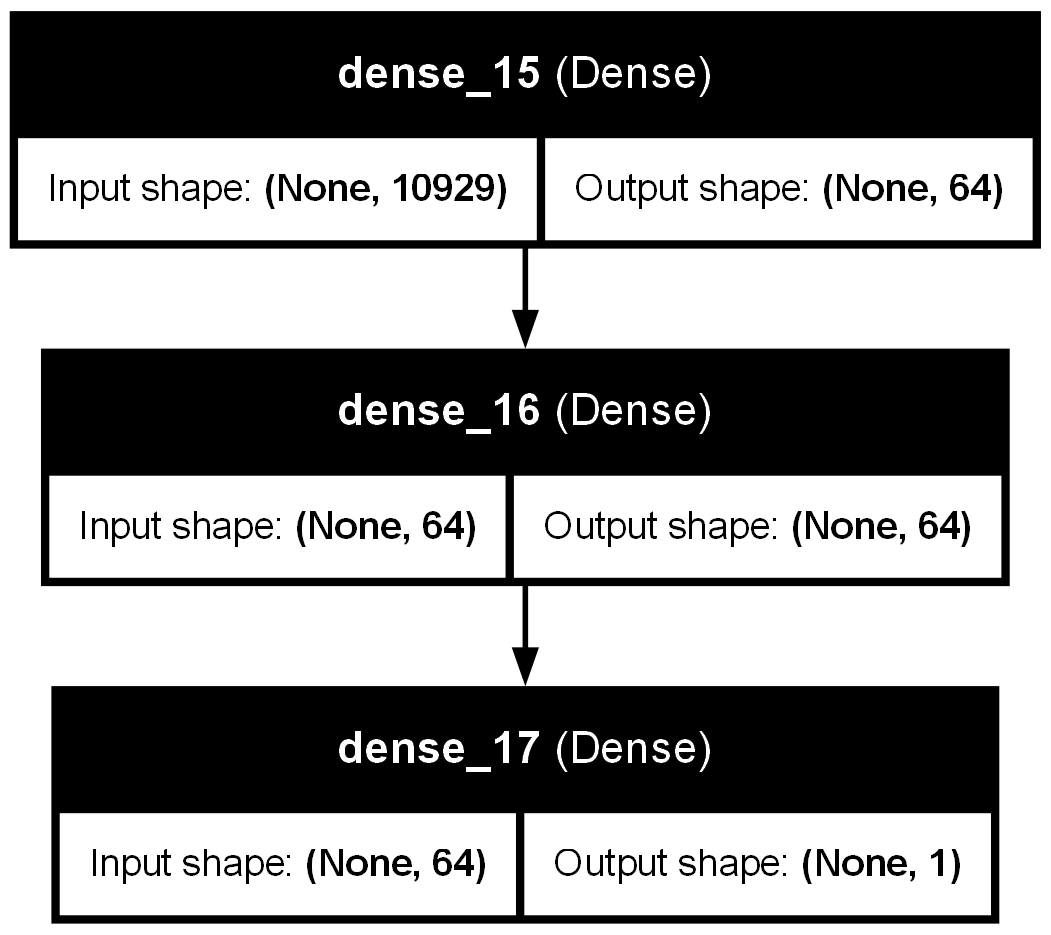

In [109]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [110]:
model.fit(X_train, 
         y_train,
          epochs = 32,
          batch_size=64,
         validation_data=(X_val, y_val))

Epoch 1/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0697 - mae: 0.3145 - mean_squared_error: 0.1527 - val_loss: 0.0533 - val_mae: 0.2579 - val_mean_squared_error: 0.1126
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0347 - mae: 0.2080 - mean_squared_error: 0.0705 - val_loss: 0.0348 - val_mae: 0.2154 - val_mean_squared_error: 0.0735
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0252 - mae: 0.1800 - mean_squared_error: 0.0506 - val_loss: 0.0315 - val_mae: 0.1967 - val_mean_squared_error: 0.0647
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0230 - mae: 0.1683 - mean_squared_error: 0.0462 - val_loss: 0.0269 - val_mae: 0.1878 - val_mean_squared_error: 0.0565
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0227 - mae: 0.1681 - mean_squared_error: 0.0459 - val_loss: 0.0260 - val_mae: 0.1794 - val_mean_squared_error: 0.0528
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0197 - mae: 0.1599 - mean_squared_error: 0.0395 - val_lo

In [59]:
# Create background dataset using local RNG
#rng = np.random.default_rng(42)
#indices = rng.choice(X_train.shape[0], 200, replace=False)
#background = X_train[indices]

# Use SHAP GradientExplainer
#explainer = shap.GradientExplainer(model, background.values)
#shap_values = explainer.shap_values(X_test[0:100].values)


# Generate summary bar plot
#shap.summary_plot(shap_values, X_test[0:100].values,   max_display=30, feature_names = X.columns )

In [90]:
X.columns

Index(['age', 'BMI', 'volume', 'ENSG00000000003.16', 'ENSG00000000419.14',
       'ENSG00000000457.14', 'ENSG00000000971.17', 'ENSG00000001036.14',
       'ENSG00000001084.13', 'ENSG00000001167.15',
       ...
       'ENSG00000308270.1', 'ENSG00000309097.1', 'ENSG00000309174.1',
       'ENSG00000309618.1', 'ENSG00000310376.1', 'ENSG00000310517.1',
       'ENSG00000310523.1', 'ENSG00000310526.1', 'ENSG00000310527.1',
       'ENSG00000310533.1'],
      dtype='object', length=10929)

## Using LIME for local interpretations

In [117]:
explainer = LimeTabularExplainer(X.values,
                                 feature_names=X.columns,
                                                mode='regression', class_names = ["scaled_pct_change"], random_state = 123)

In [118]:
# get explanation for first row
exp = explainer.explain_instance(X.iloc[0],
                                model.predict,
                                labels = X.columns)
exp.show_in_notebook(show_table=True)

C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

## Using LIME for Global interpretation
as learnt from https://www.youtube.com/watch?v=ULFHhg6R4N0&ab_channel=ADataOdyssey 

In [150]:

def return_weights(exp):
    """Extract weights from LIME explanation object for regression"""
    # Get the explanation map
    exp_map = exp.as_map()
    # Handle the case where the key might not be None
    key = list(exp_map.keys())[0] # Get the first and only key
    exp_list = exp_map[key]
    exp_list = sorted(exp_list, key=lambda x: x[0])# Sort by feature index
    exp_weight = [x[1] for x in exp_list] # extract weight
    
    return exp_weight, [x[0] for x in exp_list] # return weight and feature indices


In [151]:
weights = []
feature_indices = []
#  iterate over first 10 rows
for x in X.values[0:1000]:
    #Get explanation
    exp = explainer.explain_instance(x,
                                    model.predict,
                                    num_features= 20,
                                   # labels = X.columns
                                    )

    # get weights
    exp_weight, indices = return_weights(exp)
    weights.append(exp_weight)
    feature_indices.append(indices)



# Use the first explanation's feature indices to get column names
first_indices = feature_indices[0]
columns = [X.columns[i] for i in first_indices]

# Create dataframe

lime_weights = pd.DataFrame(data=weights, columns=columns)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━

In [156]:
lime_weights.head()

,age,BMI,ENSG00000086967.10,ENSG00000111245.18,ENSG00000125414.19,ENSG00000143549.22,ENSG00000143632.15,ENSG00000155657.29,ENSG00000164309.15,ENSG00000175084.13,ENSG00000183091.21,ENSG00000196091.15,ENSG00000198125.13,ENSG00000198727.2,ENSG00000198888.2,ENSG00000198899.2,ENSG00000210082.2,ENSG00000272106.1,ENSG00000280614.1,ENSG00000281181.1
0,0.045577,-0.031091,-0.046712,0.045468,0.027993,-0.032797,0.137075,-0.080951,0.030813,0.032692,0.058928,-0.035713,0.045454,0.056435,0.033818,-0.061724,-0.027980,0.010999,-0.055234,0.052189
1,0.048998,-0.029416,0.015241,-0.042894,0.043686,-0.018393,0.089653,0.007885,0.012448,0.013396,-0.049852,0.020225,0.043372,0.057438,0.029710,-0.063002,-0.035773,-0.017681,-0.065344,0.053161
2,0.044710,-0.071307,0.042402,0.052462,-0.037568,-0.036782,0.030654,0.017448,0.016317,0.129000,0.029676,-0.032198,0.048271,-0.060502,0.035937,-0.024248,-0.037132,-0.037485,0.060730,-0.032560
3,0.047358,-0.058721,-0.010818,-0.008423,0.030662,-0.013477,-0.058208,0.018304,0.044715,0.091213,0.031313,-0.031055,0.045806,-0.015988,-0.014154,0.041815,0.054915,-0.028007,0.039122,-0.070031
4,0.046860,-0.065911,-0.048894,0.032017,0.028569,-0.047193,0.091169,0.013717,0.033710,0.009493,-0.040846,-0.016733,-0.056693,0.043078,0.012443,-0.031074,0.013432,-0.014193,-0.058669,0.064065


Text(0.5, 0, 'Mean |Weight|')

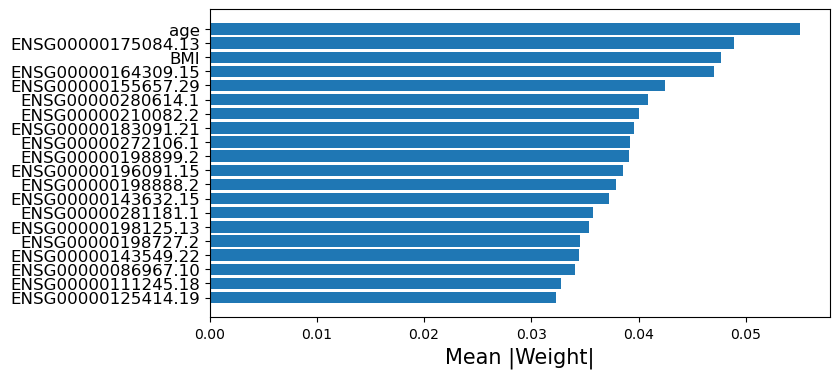

In [157]:
# geta absolute mean of LIME weights
abs_mean = lime_weights.abs().mean(axis = 0)
abs_mean = pd.DataFrame(data={"feature" : abs_mean.index, "abs_mean" : abs_mean})
abs_mean = abs_mean.sort_values("abs_mean")

# plot the mean
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y = y_ticks, width = abs_mean.abs_mean,)
plt.yticks(ticks = y_ticks, labels = y_labels, size = 12)
plt.xlabel("Mean |Weight|", size = 15)

Visualize the trend . This checks how the age values change in relation to their weight

Text(0.5, 0, 'age')

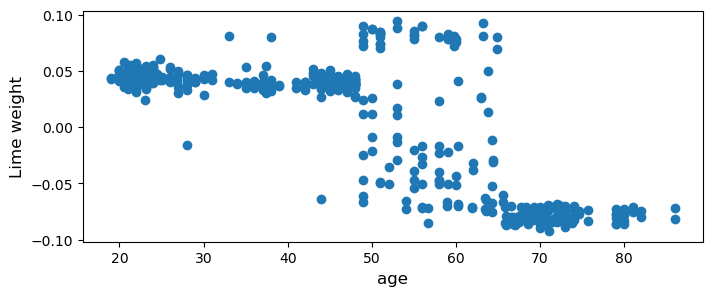

In [154]:
fig, ax = plt.subplots(nrows=1, figsize = (8,3))

# Extract weights and feature values
feature_weight = lime_weights["age"]
feature_values = X["age"][0:1000]

plt.scatter(x= feature_values, y= feature_weight)

plt.ylabel("Lime weight", size = 12)
plt.xlabel("age", size = 12)

Text(0.5, 0, 'BMI')

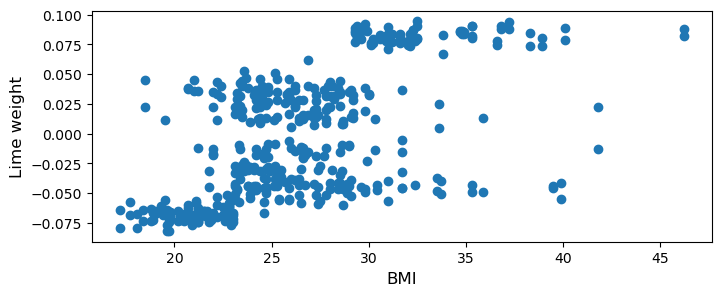

In [158]:
fig, ax = plt.subplots(nrows=1, figsize = (8,3))

# Extract weights and feature values
feature_weight = lime_weights["BMI"]
feature_values = X["BMI"][0:1000]

plt.scatter(x= feature_values, y= feature_weight)

plt.ylabel("Lime weight", size = 12)
plt.xlabel("BMI", size = 12)

Text(0.5, 0, 'ENSG00000175084.13')

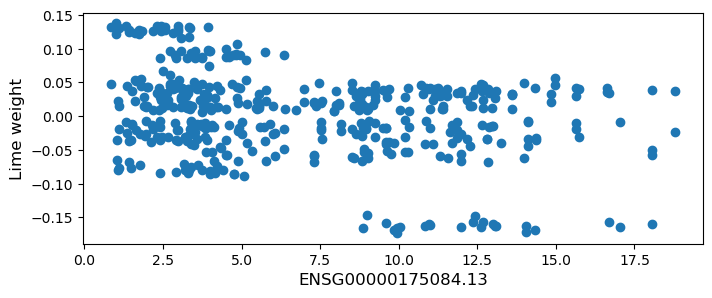

In [159]:
fig, ax = plt.subplots(nrows=1, figsize = (8,3))

# Extract weights and feature values
feature_weight = lime_weights["ENSG00000175084.13"]
feature_values = X["ENSG00000175084.13"][0:1000]

plt.scatter(x= feature_values, y= feature_weight)

plt.ylabel("Lime weight", size = 12)
plt.xlabel("ENSG00000175084.13", size = 12)

Text(0.5, 0, 'Lime Weight')

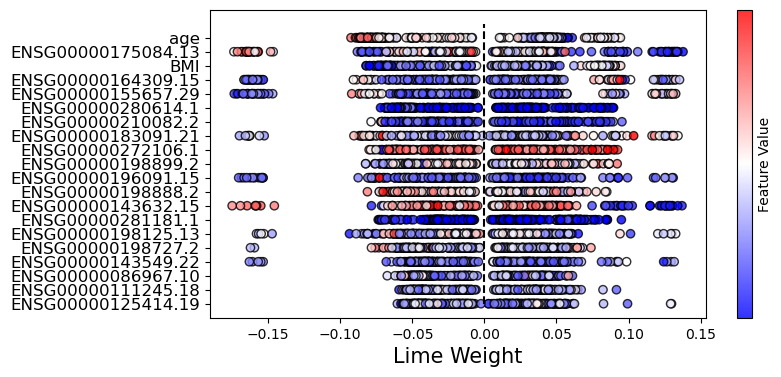

In [160]:
fig, ax = plt.subplots(nrows=1, ncols= 1, figsize=(8,4))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

# scatterplot for each feature

for i, feature in enumerate(y_labels):
    feature_weight = lime_weights[feature]
    feature_value = X[feature][0:1000]

    plt.scatter(x= feature_weight,
               y= [i]*len(feature_weight),
               c= feature_value,
               cmap = "bwr",
               edgecolors = "black",
               alpha = 0.8)

plt.vlines(x=0, ymin = 0, ymax = len(y_labels), colors = "black", linestyles = "--")
plt.colorbar(label= "Feature Value", ticks = [])

plt.yticks(ticks = y_ticks, labels=y_labels, size = 12)
plt.xlabel("Lime Weight", size = 15)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


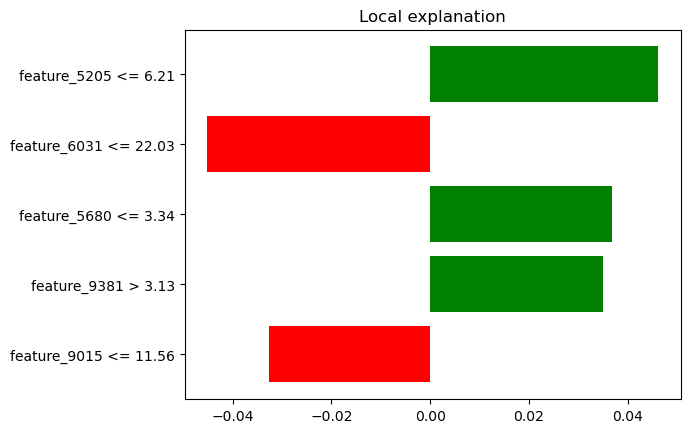

In [86]:


# LIME explainer
explainer = LimeTabularExplainer(training_data=X_train,
                                 feature_names=[f'feature_{i}' for i in range(X_train.shape[1])], mode='regression'
)

# Fix: flatten model predictions for LIME compatibility
def predict_fn(x):
    return model.predict(x).reshape(-1, 1)

# Explain a prediction
exp = explainer.explain_instance(X_test[0], predict_fn, num_features=5)
exp.as_pyplot_figure()
plt.show()
